In [1]:
%load_ext autoreload
%autoreload 2
from hmm.hmm import random_left_right_hmm_params2
from hmm.bw_numba import calc_mean_log_prob
from data.digits import load_dataset
from hmm.bw_numba import multiple_observation_sequences_from_ndarray_list
import numpy
import matplotlib.pyplot as plt

In [2]:
training_data = load_dataset(dataset='train')
digit = 0
n_samples = 12
samples = training_data[digit][:n_samples]
observations = multiple_observation_sequences_from_ndarray_list(samples)

def fitness_func(hmm_params):
    return calc_mean_log_prob(hmm_params, observations)

In [9]:
population_size = 13
n_generations = 10000
res = numpy.zeros(population_size*n_generations)
for i in range(population_size*n_generations):
    hmm_params = random_left_right_hmm_params2(4, 128)
    res[i] = fitness_func(hmm_params)

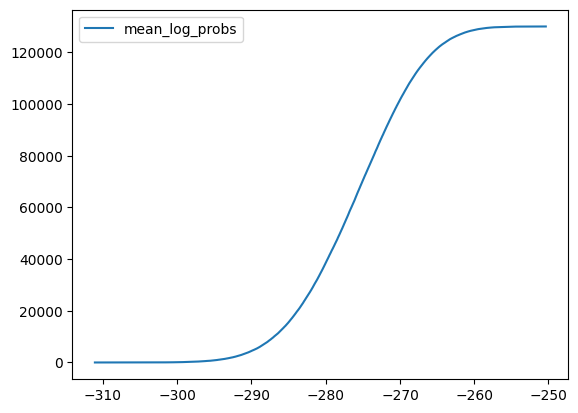

In [10]:
y = numpy.arange(population_size*n_generations)
x = numpy.sort(res)

plt.plot(x, y, label='mean_log_probs')

plt.legend()
plt.show()


In [11]:
numpy.mean(res)

-250.36002674264094